# Skin Cancer Classification Challenge

**Summary : ** skin cancer.

## Preliminaries and Imports

In [1]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from PIL import Image
from random import choice
import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D,Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score


from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

%matplotlib inline

Using TensorFlow backend.


## I. Load Data

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
%%time
meta = pd.read_csv("../data/label_learn.csv", sep = ";")

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 5.17 ms


In [3]:
meta.head()

,name,label
0,0000000.jpg,benign
1,0000002.jpg,malignant
2,0000006.jpg,benign
3,0000008.jpg,benign
4,0000009.jpg,benign


In [4]:
%%time
train_list = os.listdir("../data/resized_train/")
len(train_list) == len(meta.name)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.7 ms


In [5]:
train_list.sort() == list(meta.name).sort()

True

In [6]:
%%time
X_train = np.array([np.array(Image.open("../data/resized_train/"+fname)) for fname in meta.name])
Y_train = [1 if x=="malignant" else 0 for x in meta.label]
Y_train = np.array(Y_train)

CPU times: user 21.8 s, sys: 1.71 s, total: 23.5 s
Wall time: 23.5 s


In [7]:
print(X_train.shape)
print(len(Y_train))
X_train.shape[0] == len(meta.name) == len(Y_train)

(8581, 299, 299, 3)
8581


True

In [8]:
#control
print(meta.name[0:5])
print(Y_train[0:5])
print(meta.label[0:5])

0    0000000.jpg
1    0000002.jpg
2    0000006.jpg
3    0000008.jpg
4    0000009.jpg
Name: name, dtype: object
[0 1 0 0 0]
0       benign
1    malignant
2       benign
3       benign
4       benign
Name: label, dtype: object


## II. Data Preparation

- **Class weights**

In [9]:
class_weight_or = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

- **Data splitting**

In [10]:
#data splitting
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state=42, train_size=0.80)

/home/dvp_tran/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


- **Resampling**

In [11]:
temp = sum(Y_train)
sample_size = temp*2700/(374+254)  #1372
sample_size

2325

In [12]:
def random_undersampling(X, Y,sample_size = sample_size, n_sample=1):
    """
    X,y : numpy arrays
    return :
    5 random ensemble of indices general_balenced_set:
        general_balenced_set[0] = the shuffeled indices that inssure the class balance
    """
    indices = np.array(range(len(Y)))
    positive_samples = indices[Y==1]
    #print(type(positive_samples))
    negative_samples = indices[Y==0]
    #print(type(negative_samples))
    general_balenced_set = []
    for k in range(n_sample):
        indices_ = np.random.choice(negative_samples, sample_size, replace=False)
        #print(len(indices_))
        # append positive and negative
        balenced_set = np.append(indices_, positive_samples)
        #print(len(balenced_set))
        # shuffle indices
        np.random.shuffle(balenced_set)
        #print(len(balenced_set))
        general_balenced_set.append(balenced_set)
    return general_balenced_set

In [13]:
general_balenced_set = random_undersampling(X_train,Y_train)
X_train = X_train[general_balenced_set]
Y_train = Y_train[general_balenced_set]

## III. Deep Learning with Transfer Learning

In [14]:
weights_path = '../model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
epochs = 500
batch_size = 50

- **Using RESNET : **

In [15]:
#load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299,299,3))
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [16]:
#adding top layers
    #sequentialy
add_model = Sequential()
add_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:])) #Flatten/GlobalAveragePooling2D
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [17]:
from keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    [w_0, w_1] : weight of 0 class and weight of 1 class
    """
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        #y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights[1] + (1 - y_true) * K.log(1 - y_pred) * weights[0]
        loss = -K.sum(loss, -1)
        return loss

    return loss


In [18]:
class_weight_or

array([ 0.54296381,  6.31885125])

In [19]:
loss1 = weighted_categorical_crossentropy(class_weight_or) #(np.array([0.8,4]))

In [20]:
#freeze lower layers of the model
#for layer in model.layers[:]:
    #layer.trainable = False
for layer in model.layers[0:]:
    layer.trainable = True
    

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())




#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss="binary_crossentropy", #binary_crossentropy
              metrics=[sensitivity, specificity,"accuracy"])

In [21]:
%%time
#Lets define the image transormations that we wan

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         rotation_range=40)

val_datagen = ImageDataGenerator()
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_one_input(X1, y):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]

def val_datagen_(X1, y):
    genX1 = val_datagen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]
#Finally create out generator
gen_flow_train = gen_flow_for_one_input(X_train, Y_train)
#gen_flow_val = gen_flow_for_one_input(X_valid, Y_valid)
gen_flow_val = val_datagen_(X_valid, Y_valid)

from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs_to_wait_for_improve = 30
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(weights_path + 'BestKerasResnet50_flat_3_loss_no_weight_raw.h5', monitor='val_loss',
                                      verbose=1, save_best_only=True, mode='min')
#fit the model
model.fit_generator(gen_flow_train, validation_data=(X_valid, Y_valid),
                    steps_per_epoch=int(np.ceil(len(X_train)/batch_size)),
                    epochs=500, verbose=1, callbacks=[early_stopping_callback, checkpoint_callback],
                    class_weight = class_weight_or)

Epoch 1/500
57/57 [==============================] - 73s 1s/step - loss: 0.5170 - sensitivity: 0.0971 - specificity: 0.9275 - acc: 0.7702 - val_loss: 0.4060 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_acc: 0.9196
Epoch 2/500
57/57 [==============================] - 52s 905ms/step - loss: 0.3936 - sensitivity: 0.1220 - specificity: 0.9846 - acc: 0.8249 - val_loss: 0.3221 - val_sensitivity: 0.0251 - val_specificity: 0.9974 - val_acc: 0.9196
Epoch 3/500
57/57 [==============================] - 51s 899ms/step - loss: 0.3588 - sensitivity: 0.2540 - specificity: 0.9668 - acc: 0.8296 - val_loss: 0.2632 - val_sensitivity: 0.1746 - val_specificity: 0.9875 - val_acc: 0.9208
Epoch 4/500
57/57 [==============================] - 51s 900ms/step - loss: 0.3156 - sensitivity: 0.3787 - specificity: 0.9630 - acc: 0.8480 - val_loss: 0.2375 - val_sensitivity: 0.2631 - val_specificity: 0.9759 - val_acc: 0.9196
Epoch 5/500
57/57 [==============================] - 51s 900ms/step - loss: 0.3

57/57 [==============================] - 51s 899ms/step - loss: 0.2280 - sensitivity: 0.7255 - specificity: 0.9392 - acc: 0.8940 - val_loss: 0.1600 - val_sensitivity: 0.5633 - val_specificity: 0.9560 - val_acc: 0.9266
Epoch 19/500
57/57 [==============================] - 51s 899ms/step - loss: 0.2221 - sensitivity: 0.7494 - specificity: 0.9388 - acc: 0.8989 - val_loss: 0.1559 - val_sensitivity: 0.5560 - val_specificity: 0.9573 - val_acc: 0.9272
Epoch 20/500
57/57 [==============================] - 51s 898ms/step - loss: 0.2315 - sensitivity: 0.7438 - specificity: 0.9345 - acc: 0.8922 - val_loss: 0.1537 - val_sensitivity: 0.5516 - val_specificity: 0.9586 - val_acc: 0.9278
Epoch 21/500
57/57 [==============================] - 49s 863ms/step - loss: 0.2246 - sensitivity: 0.7424 - specificity: 0.9345 - acc: 0.8929 - val_loss: 0.1598 - val_sensitivity: 0.5790 - val_specificity: 0.9502 - val_acc: 0.9237
Epoch 22/500
57/57 [==============================] - 49s 863ms/step - loss: 0.2119 - sen

57/57 [==============================] - 51s 898ms/step - loss: 0.1943 - sensitivity: 0.7785 - specificity: 0.9443 - acc: 0.9098 - val_loss: 0.1408 - val_sensitivity: 0.5638 - val_specificity: 0.9594 - val_acc: 0.9295
Epoch 37/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1960 - sensitivity: 0.7590 - specificity: 0.9459 - acc: 0.9084 - val_loss: 0.1450 - val_sensitivity: 0.6276 - val_specificity: 0.9549 - val_acc: 0.9301
Epoch 38/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1992 - sensitivity: 0.7706 - specificity: 0.9394 - acc: 0.9056 - val_loss: 0.1501 - val_sensitivity: 0.6407 - val_specificity: 0.9460 - val_acc: 0.9231
Epoch 39/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1964 - sensitivity: 0.7680 - specificity: 0.9449 - acc: 0.9066 - val_loss: 0.1495 - val_sensitivity: 0.6856 - val_specificity: 0.9493 - val_acc: 0.9289
Epoch 40/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1905 - sen

Epoch 57/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1719 - sensitivity: 0.8077 - specificity: 0.9554 - acc: 0.9242 - val_loss: 0.1319 - val_sensitivity: 0.6265 - val_specificity: 0.9708 - val_acc: 0.9441
Epoch 58/500
57/57 [==============================] - 49s 868ms/step - loss: 0.1723 - sensitivity: 0.7967 - specificity: 0.9554 - acc: 0.9227 - val_loss: 0.1361 - val_sensitivity: 0.4863 - val_specificity: 0.9634 - val_acc: 0.9400
Epoch 59/500
57/57 [==============================] - 50s 871ms/step - loss: 0.1756 - sensitivity: 0.7783 - specificity: 0.9530 - acc: 0.9165 - val_loss: 0.1419 - val_sensitivity: 0.6761 - val_specificity: 0.9574 - val_acc: 0.9348
Epoch 60/500
57/57 [==============================] - 51s 899ms/step - loss: 0.1746 - sensitivity: 0.7928 - specificity: 0.9532 - acc: 0.9227 - val_loss: 0.1281 - val_sensitivity: 0.4976 - val_specificity: 0.9772 - val_acc: 0.9423
Epoch 61/500
57/57 [==============================] - 49s 864ms/step - loss:

Epoch 78/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1609 - sensitivity: 0.8210 - specificity: 0.9598 - acc: 0.9315 - val_loss: 0.1344 - val_sensitivity: 0.6193 - val_specificity: 0.9695 - val_acc: 0.9441
Epoch 79/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1497 - sensitivity: 0.8293 - specificity: 0.9627 - acc: 0.9340 - val_loss: 0.1338 - val_sensitivity: 0.6416 - val_specificity: 0.9656 - val_acc: 0.9400
Epoch 80/500
57/57 [==============================] - 49s 862ms/step - loss: 0.1515 - sensitivity: 0.8233 - specificity: 0.9602 - acc: 0.9340 - val_loss: 0.1480 - val_sensitivity: 0.6356 - val_specificity: 0.9543 - val_acc: 0.9319
Epoch 81/500
57/57 [==============================] - 49s 862ms/step - loss: 0.1408 - sensitivity: 0.8234 - specificity: 0.9662 - acc: 0.9375 - val_loss: 0.1400 - val_sensitivity: 0.6192 - val_specificity: 0.9606 - val_acc: 0.9354
Epoch 82/500
57/57 [==============================] - 49s 863ms/step - loss:

Epoch 99/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1399 - sensitivity: 0.8209 - specificity: 0.9665 - acc: 0.9403 - val_loss: 0.1316 - val_sensitivity: 0.5583 - val_specificity: 0.9756 - val_acc: 0.9458
Epoch 100/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1239 - sensitivity: 0.8625 - specificity: 0.9677 - acc: 0.9448 - val_loss: 0.1361 - val_sensitivity: 0.5293 - val_specificity: 0.9764 - val_acc: 0.9429
Epoch 101/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1313 - sensitivity: 0.8546 - specificity: 0.9692 - acc: 0.9441 - val_loss: 0.1379 - val_sensitivity: 0.4489 - val_specificity: 0.9829 - val_acc: 0.9429
Epoch 102/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1296 - sensitivity: 0.8255 - specificity: 0.9687 - acc: 0.9417 - val_loss: 0.1277 - val_sensitivity: 0.5183 - val_specificity: 0.9835 - val_acc: 0.9487
Epoch 103/500
57/57 [==============================] - 49s 863ms/step - l

Epoch 120/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1139 - sensitivity: 0.8613 - specificity: 0.9760 - acc: 0.9529 - val_loss: 0.1426 - val_sensitivity: 0.6673 - val_specificity: 0.9650 - val_acc: 0.9418
Epoch 121/500
57/57 [==============================] - 49s 863ms/step - loss: 0.0991 - sensitivity: 0.9019 - specificity: 0.9738 - acc: 0.9568 - val_loss: 0.1408 - val_sensitivity: 0.6373 - val_specificity: 0.9682 - val_acc: 0.9423
Epoch 122/500
57/57 [==============================] - 49s 863ms/step - loss: 0.1037 - sensitivity: 0.8916 - specificity: 0.9759 - acc: 0.9575 - val_loss: 0.1450 - val_sensitivity: 0.5906 - val_specificity: 0.9661 - val_acc: 0.9383
Epoch 123/500
57/57 [==============================] - 49s 862ms/step - loss: 0.1029 - sensitivity: 0.8831 - specificity: 0.9796 - acc: 0.9610 - val_loss: 0.1371 - val_sensitivity: 0.5792 - val_specificity: 0.9758 - val_acc: 0.9453
Epoch 124/500
57/57 [==============================] - 49s 862ms/step - 

## IV. Visualize  TSNE

In [22]:
%matplotlib inline
import numpy as np
# visualize the points' distribution of train data using features built from base_model
import matplotlib.pyplot as plt
# dimension reduction
from sklearn.manifold import TSNE 
import numpy as np

def t_sne_vis(name, base_model, x_processed_images, random_state, labels,perplexity = 30):
    """
    :param name: the name of the cnn model used to build features
    :param base_model: the model obj
    :param x_processed_images: the input images for our model
    :param random_state: for fixing the results
    :param labels: 0/1 classification labels
    :return:
    the graph of image distribution based on features extracted from the model and the t-sne features
    """
    # convert data to images
    print('Converting data points to composite image')
    X_train = x_processed_images
    print('we got %d different images of shape %dx%d ' % (len(X_train), X_train.shape[1], X_train.shape[1]))
    print('build usefull features from the selected model')
    features = base_model.predict(X_train)
    x_data1 = np.asarray(features).astype('float64')
    x_data1 = x_data1.reshape((x_data1.shape[0], -1))
    # perform t-SNE embedding
    print('performing t-sne reduction')
    vis_data = TSNE(perplexity=perplexity, random_state=random_state).fit_transform(x_data1)
    # plot the result
    fig = plt.figure(figsize=(15, 15))
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("winter", 2))
    plt.colorbar(ticks=range(2))
    plt.clim(0, 1)
    plt.title(name)
    plt.grid()
    plt.show()
    fig.savefig('tsne_vis_'+name+'.png')
    return vis_data


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

visualizing for Resnet
Converting data points to composite image
we got 1717 different images of shape 299x299 
build usefull features from the selected model


/home/dvp_tran/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("av..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


performing t-sne reduction


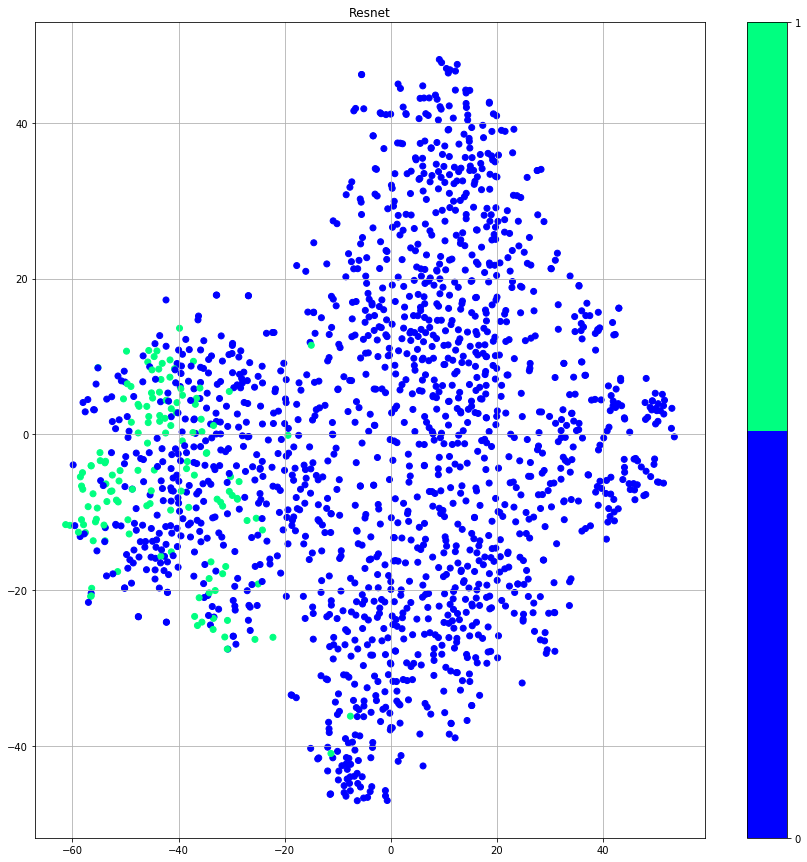

In [24]:
name = 'Resnet'
print('visualizing for %s' %name)
base_model_ = Model(input=model.input, output=model.get_layer('avg_pool').output)
tsne_feats = t_sne_vis(name, base_model_, X_valid, np.random.RandomState(42), Y_valid,perplexity=30)

## V. Evaluate Model

In [25]:
model = load_model(weights_path+"BestKerasResnet50_flat_3_loss_no_weight_raw.h5", custom_objects={'sensitivity': sensitivity,
                                                                             "specificity":specificity})
score = model.evaluate(X_valid, Y_valid, verbose=1)
print('Test loss:', score[0])
print('Test sensitivity:', score[1])
print('Test specificity:', score[2])
print('Test acc:', score[3])

1717/1717 [==============================] - 10s 6ms/step
('Test loss:', 0.12710283647617351)
('Test sensitivity:', 0.52138001924347033)
('Test specificity:', 0.98349518239949429)
('Test acc:', 0.94758299359347697)


In [26]:
#compute metrics
pred = model.predict(X_valid)
average_precision = average_precision_score(Y_valid, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.71


Text(0.5,1,u'2-class Precision-Recall curve: AP=0.71')

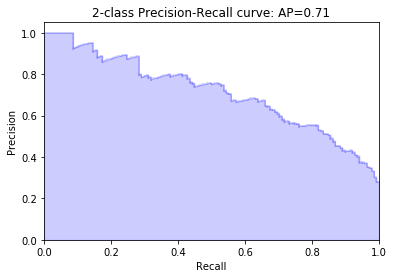

In [27]:
precision, recall, _ = precision_recall_curve(Y_valid, pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [28]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)

In [29]:
generate_results

<function __main__.generate_results>

#compute log loss
pred = model.predict(X_valid)
log_loss(Y_valid,pred)

## VI. Retrain on full dataset